<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/6a_autocodificadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocodificadores
En este libreta programaremos un autocodificador contractivo simple usando Pytorch y lo usaremos para reducir dimensiones en tres conjuntos de datos. 

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine, load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
from torch.nn import Sequential
from torch.nn import Linear, Sigmoid
from torch.optim import Adam

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url

from itertools import islice as take

URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/iris/iris.csv'
base_dir = '../data/iris/'
filename = 'iris.csv'
filepath = os.path.join(base_dir, 'iris.csv')

SEED = 1
torch.manual_seed(SEED)

Definimos nuestro autocodificador en una subclase, donde tanto el codificador como el decodificador tienen arquitecturas secuenciales. 

In [2]:
class Autocodificador(torch.nn.Module):
  def __init__(self, d, n_ocultas, n_salidas):
    super(Autocodificador, self).__init__()  
    
    self.cod = Sequential(Linear(d, n_ocultas),
                          Sigmoid(),
                          Linear(n_ocultas, n_salidas))
    self.dec = Sequential(Linear(n_salidas, n_ocultas),
                          Sigmoid(),
                          Linear(n_ocultas, d))

  def forward(self, x):
    z = self.cod(x)
    x = self.dec(z)

    return x

Probemos nuestro autocodificador con datos generados aleatorioriamente.

In [3]:
ac = Autocodificador(d=4, n_ocultas=5, n_salidas=2)
x = torch.rand(16,4)
print(x)
print(x.shape)
print(ac.cod(x))
print(ac.cod(x).shape)
print(ac(x))
print(ac(x).shape)

tensor([[0.6818, 0.7479, 0.0369, 0.7517],
        [0.1484, 0.1227, 0.5304, 0.4148],
        [0.7937, 0.2104, 0.0555, 0.8639],
        [0.4259, 0.7812, 0.6607, 0.1251],
        [0.6004, 0.6201, 0.1652, 0.2628],
        [0.6705, 0.5896, 0.2873, 0.3486],
        [0.9579, 0.4075, 0.7819, 0.7165],
        [0.1768, 0.0748, 0.9799, 0.5261],
        [0.8427, 0.6036, 0.6608, 0.8735],
        [0.9741, 0.1682, 0.5625, 0.8731],
        [0.8622, 0.8106, 0.1381, 0.1399],
        [0.1976, 0.5628, 0.9983, 0.1842],
        [0.7664, 0.2233, 0.0299, 0.3937],
        [0.7881, 0.9642, 0.1895, 0.6085],
        [0.9314, 0.8313, 0.8116, 0.8553],
        [0.8163, 0.6291, 0.1581, 0.0801]])
torch.Size([16, 4])
tensor([[-0.0167,  0.3971],
        [-0.0121,  0.3746],
        [-0.0357,  0.3708],
        [-0.0053,  0.3707],
        [-0.0306,  0.3797],
        [-0.0271,  0.3705],
        [-0.0146,  0.3322],
        [ 0.0047,  0.3532],
        [-0.0021,  0.3558],
        [-0.0259,  0.3354],
        [-0.0394,  0.3696],

Creamos una subclase de `Dataset` para cargar los tres conjuntos de datos que utilizaremos. 

In [4]:
class MiDS(Dataset):    
    def __init__(self, X):
        self.x = X

    def __getitem__(self, i):
        return self.x[i]

    def __len__(self):
        return len(self.x)

Probamos esta subclase con los datos generados aleatoriamente.

In [6]:
ds = MiDS(x)
print(len(ds))
print(ds[1])

16
tensor([0.1484, 0.1227, 0.5304, 0.4148])


Para hacer más fácil la generación de los cargadores de datos de los tres conjuntos de datos, definimos una función que toma un arreglo de NumPy y el tamaño de lote, estandariza los datos y crea y regresa el cargador de datos.

In [7]:
def numpy_a_dataloader(X, t_lote):
  sc = StandardScaler()
  X = sc.fit_transform(X).astype('float32')

  ds = MiDS(X)
  print('Tamaño del conjunto de datos: {0}'.format(len(ds)))

  dl = DataLoader(ds, 
                  batch_size=t_lote, 
                  shuffle=True)

  for x in take(dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')

  return X, dl

Probamos nuestra función con los datos generados aleatoriamente.

In [8]:
x, dl = numpy_a_dataloader(x, 2)

Tamaño del conjunto de datos: 16
x shape=torch.Size([2, 4]) dtype=torch.float32


Encapsulamos la definición, el entrenamiento y la inferencia de los autocodificadores que vamos evaluar en una clase.

In [9]:
class Modelo:
  def __init__(self, d, n_ocultas=10, n_salidas=2):
    self.ac = Autocodificador(d=d, n_ocultas=n_ocultas, n_salidas=n_salidas)
 
  def fit(self, X, n_epocas=100):
    opt = Adam(self.ac.parameters())

    perdidas = []
    for e in range(n_epocas):   
      perdidas_epoca = [] 
      for r in X:
        xs = self.ac(r)
        p = torch.nn.functional.mse_loss(xs, r)
        opt.zero_grad()
        p.backward()
        opt.step()
        perdidas_epoca.append(p.item())
      
      perdidas.append(np.mean(perdidas_epoca))

    return perdidas

  def transform(self, X):
    with torch.no_grad():
      return self.ac.cod(torch.from_numpy(X)).numpy()

Finalmente, creamos una función para visualizar los datos mapeados por el codificador y comparándolos con los de PCA.

In [44]:
def grafica_mapeos(X_ac, X_pca, y, etiquetas):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  print('Datos Totales: ', X_ac.shape[0])

  for e in etiquetas:
    ax1.scatter(X_ac[y==e, 0], 
                X_ac[y==e, 1], 
                label=e)
    print('Datos en clase {} con autocodificador: '.format(e), (X_ac[y==e, 0].shape[0]))

    ax2.scatter(X_pca[y==e, 0], 
                X_pca[y==e, 1], 
                label=e)
    print('Datos en clase {} con PCA: '.format(e), (X_pca[y==e, 0].shape[0]))
    
  ax1.set_title('Autocodificador')
  ax2.set_title('PCA')

## Conjunto de datos de la flor Iris
Se carga el conjunto de datos Iris usando las funciones predefinidas de PyTorch:

In [36]:
download_url(URL, base_dir, filename)

Using downloaded and verified file: ../data/iris/iris.csv


Leemos el archivo y mostramos algunos ejemplos.

In [37]:
columns = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv('../data/iris/iris.csv', names=columns)
df.head()

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Extraemos los atributos de las flores en un arreglo de NumPy (omitiendo la clase) y creamos nuestro cargador de datos.

In [38]:
Xiris = df.loc[:, df.columns!='clase'].to_numpy()
irisdim = Xiris.shape[-1]
Xiris, irisdl = numpy_a_dataloader(Xiris, 10)

Tamaño del conjunto de datos: 150
x shape=torch.Size([10, 4]) dtype=torch.float32


Instanciamos y entrenamos nuestro autocodificador con el cargador de datos creado.

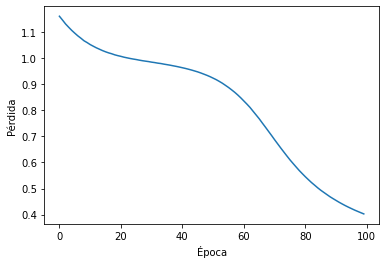

In [39]:
irisac = Modelo(irisdim, 2, 2)
perdidas = irisac.fit(irisdl)

plt.plot(perdidas)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Mapeamos los datos a los vectores generador por el codificador entrenado.

In [40]:
X_irisac = irisac.transform(Xiris)

Se visualizan los vectores latentes y se comparan con los producidos por _Principal Component Analysis_ (PCA):



Datos Totales:  150
Datos en clase Iris-setosa con autocodificador:  50
Datos en clase Iris-setosa con PCA:  50
Datos en clase Iris-versicolor con autocodificador:  50
Datos en clase Iris-versicolor con PCA:  50
Datos en clase Iris-virginica con autocodificador:  50
Datos en clase Iris-virginica con PCA:  50


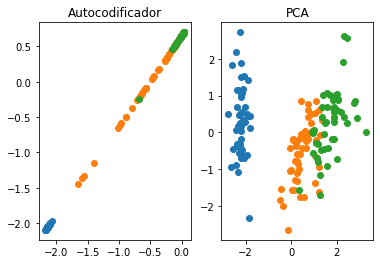

In [45]:
irispca = PCA(n_components=2)
X_irispca = irispca.fit_transform(Xiris)
grafica_mapeos(X_irisac, X_irispca, df.clase, list(df.clase.unique()))

## Conjunto de datos de vinos

Se carga el conjunto de datos Wine usando las funciones predefinidas de scikit-learn y se crea el cargador de datos:

In [46]:
vino = load_wine()
vinodim = vino.data.shape[-1]
Xvino, vinodl = numpy_a_dataloader(X=vino.data, t_lote=10)

Tamaño del conjunto de datos: 178
x shape=torch.Size([10, 13]) dtype=torch.float32


Instanciamos y entrenamos el autocodificador con el cargador de datos creado.

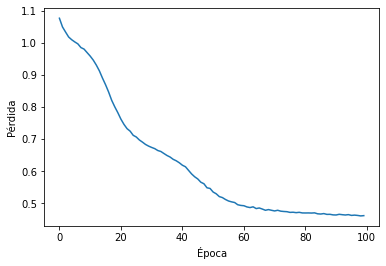

In [47]:
vinoac = Modelo(vinodim)
perdidas = vinoac.fit(vinodl)

plt.plot(perdidas)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Se mapea el conjunto de datos a vectores producidos por el codificador entrenado.

In [48]:
X_vinoac = vinoac.transform(Xvino)

Se visualizan los vectores latentes y se comparan con los producidos por _Principal Component Analysis_ (PCA):

Datos Totales:  178
Datos en clase 0 con autocodificador:  59
Datos en clase 0 con PCA:  59
Datos en clase 1 con autocodificador:  71
Datos en clase 1 con PCA:  71
Datos en clase 2 con autocodificador:  48
Datos en clase 2 con PCA:  48


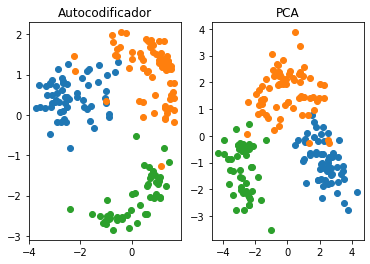

In [49]:
pca = PCA(n_components=2)
X_vinopca = pca.fit_transform(Xvino)
grafica_mapeos(X_vinoac, X_vinopca, vino.target, np.unique(vino.target))

## Conjunto de datos de dígitos

Se carga el conjunto de datos Digits usando las funciones predefinidas de scikit-learn y se crea el cargador de datos.

In [50]:
digitos = load_digits()
digitosdim = digitos.data.shape[-1]
Xdigitos, digitosdl = numpy_a_dataloader(X=digitos.data, t_lote=10)

Tamaño del conjunto de datos: 1797
x shape=torch.Size([10, 64]) dtype=torch.float32


Se instancia y entrena un autcodificador con el cargador de datos creado.

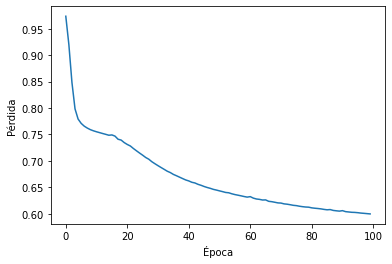

In [51]:
digitosac = Modelo(digitosdim)
perdidas = digitosac.fit(digitosdl)

plt.plot(perdidas)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Se mapea el conjunto de datos con el codificador entrenado.

In [52]:
X_digitosac = digitosac.transform(Xdigitos)

Se visualizan los vectores latentes y se comparan con los producidos por _Principal Component Analysis_ (PCA).

Datos Totales:  1797
Datos en clase 0 con autocodificador:  178
Datos en clase 0 con PCA:  178
Datos en clase 1 con autocodificador:  182
Datos en clase 1 con PCA:  182
Datos en clase 2 con autocodificador:  177
Datos en clase 2 con PCA:  177
Datos en clase 3 con autocodificador:  183
Datos en clase 3 con PCA:  183
Datos en clase 4 con autocodificador:  181
Datos en clase 4 con PCA:  181
Datos en clase 5 con autocodificador:  182
Datos en clase 5 con PCA:  182
Datos en clase 6 con autocodificador:  181
Datos en clase 6 con PCA:  181
Datos en clase 7 con autocodificador:  179
Datos en clase 7 con PCA:  179
Datos en clase 8 con autocodificador:  174
Datos en clase 8 con PCA:  174
Datos en clase 9 con autocodificador:  180
Datos en clase 9 con PCA:  180


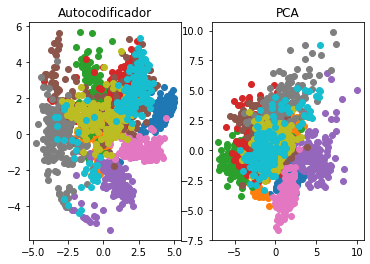

In [53]:
digitospca = PCA(n_components=2)
X_digitospca = digitospca.fit_transform(Xdigitos)
grafica_mapeos(X_digitosac, X_digitospca, digitos.target, np.unique(digitos.target))